In [35]:
# 라이브러리 부르기
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from tqdm.auto import tqdm
import concurrent.futures
import functools

In [36]:
pip install -q -U tensorboard

In [37]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [38]:
train_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/train.csv')
test_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/test.csv')

train_all_input_files = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'+train_csv['input_img']
train_all_label_files = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'+train_csv['label_img']
# 파일이름 + 경로

In [39]:
len(train_all_input_files), len(train_all_label_files)

(622, 622)

In [40]:
train_all_input_files[0], train_all_label_files[0]

('/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10000.png',
 '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/train_label_10000.png')

In [41]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

val_input_files = train_all_input_files[:60].to_numpy()
val_label_files = train_all_label_files[:60].to_numpy()

In [42]:
len(train_input_files), len(train_label_files), len(val_input_files), len(val_label_files)

(562, 562, 60, 60)

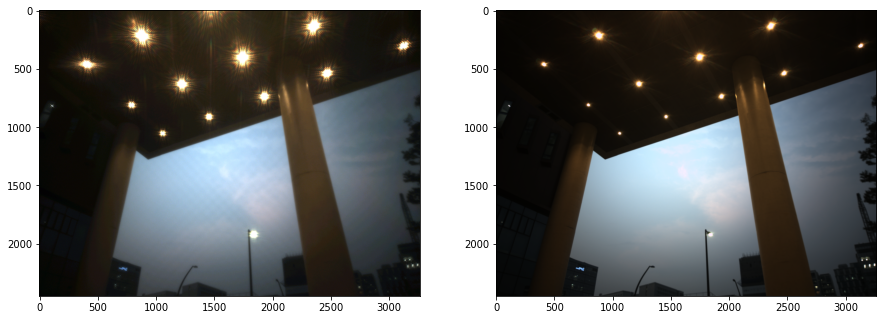

/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10060.png /content/gdrive/MyDrive/dacon_camera/data/train_label_img/train_label_10060.png 



In [43]:
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break

In [44]:
BATCH_SIZE = 8
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 5
dropout_rate = 0.1

In [45]:
def cut_img(img_path_list, save_path, stride):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        img = cv2.imread(path)
        for top in range(0, img.shape[0], stride):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                np.save(f'{save_path}{img_size}/{num}.npy', piece)
                num+=1

In [46]:
cut_img(train_input_files, './data/train_input_img_', 128)
cut_img(train_label_files, './data/train_label_img_', 128)
cut_img(val_input_files, './data/val_input_img_', 128)
cut_img(val_label_files, './data/val_label_img_', 128)

KeyboardInterrupt: ignored

In [ ]:
train_inp_files = glob(f'./data/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./data/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./data/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./data/val_label_img_{img_size}/*.npy')

In [ ]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [ ]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

In [ ]:
def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    inp, targ = augmentation(inp, targ)
    
    return inp, targ

def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    return inp, targ

def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    
    return inp, targ

def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    
    return inp, targ

def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
        
    return inp, targ

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

In [ ]:
# 3. Generator 생성
# 인코더 부분

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
# 디코더 부분

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
# Gernerator 생성

def Generator():
  inputs = tf.keras.layers.Input(shape=[None, None,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# 모델 구조 확인

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
# Generator 손실 함수

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
# 4. Discriminator 생성

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
# 모델 구조 확인

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
# Discriminator 손실

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
# 5. 준비
# 옵티마이저 설정

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# 체크포인트 기능

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# 이미지 생성 유틸

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# 6. 훈련 준비

EPOCHS = 30

import datetime
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    for example_input, example_target in test_ds.take(5):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      if (n+1) % 3000 == 0:
        print('3000개 데이터 처리')
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# 7. 훈련 시작
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}
import time

fit(train_dataset, EPOCHS, val_dataset)

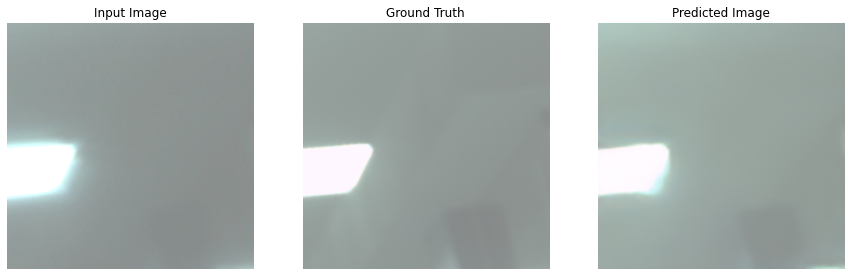

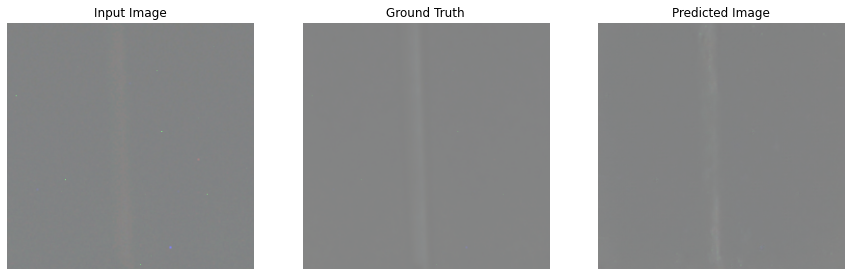

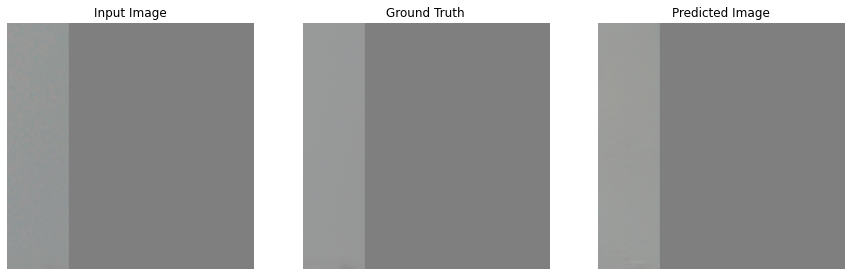

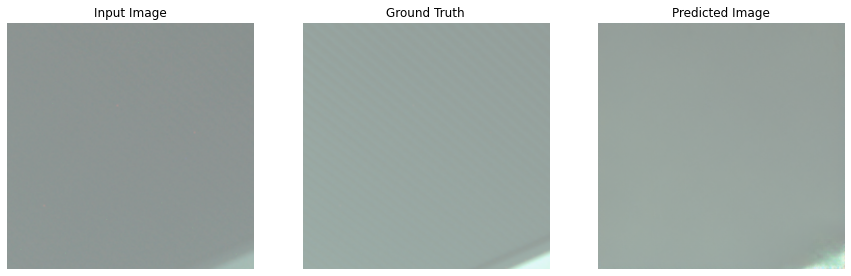

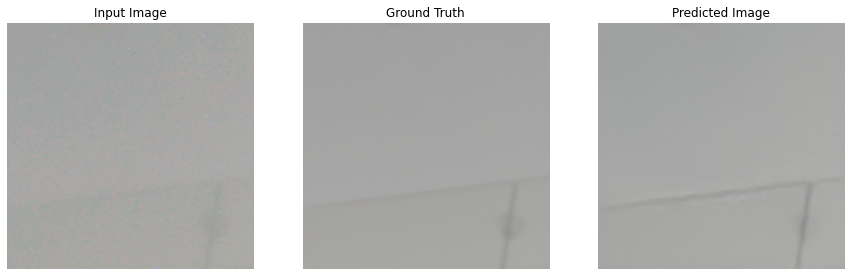

In [47]:
for inp, tar in val_dataset.take(5):
  generate_images(generator, inp, tar)

In [48]:
def predict(test_input):

  for img in test_input :
    prediction = generator(img, training=True)
    plt.figure(figsize=(15,15))

    display_list = [img[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    print(type(prediction))
    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

In [69]:
test_ds = tf.data.Dataset.list_files('/content/gdrive/MyDrive/dacon_camera/data/test_input_img/*.png',)
test_ds = test_ds.map(load_image_test)
test_ds = test_ds.batch(BATCH_SIZE)

In [70]:
test_ds.element_spec

TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)

In [71]:
predict(test_ds)

ResourceExhaustedError: ignored

In [62]:
def save_result(test_input):
  result = []

  for img in test_input :
    prediction = generator(img, training=True)
    plt.figure(figsize=(15,15))

    display_list = [img[0], prediction[0]]
    result.append(display_list[1])
  
  return result

In [63]:
from PIL import Image


result = save_result(test_ds)
os.makedirs('/content/gdrive/MyDrive/dacon_camera/Submis')
sub_imgs = []
for i, img in enumerate(result):
    tf.keras.preprocessing.image.save_img(f'/content/gdrive/MyDrive/dacon_camera/Submis/test_{20000+i}.png',img)

ResourceExhaustedError: ignored